In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import h5py
import math

from keras.models import Model
from keras.layers import Input, Activation, BatchNormalization, Conv2D, Conv3D
from keras.layers import Lambda, Concatenate, MaxPooling2D, Maximum, Add
from keras.initializers import RandomNormal
from keras.optimizers import SGD
from keras.losses import MeanSquaredError
from keras.callbacks import Callback,LearningRateScheduler
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

In [ ]:
def load_train_dataset():
    """
    Load training dataset from Google Drive

    Returns:
    clean_image -- Clean image patches
    clean_image -- Hazy image patches
    transmission_value -- Transmission value which convert clean image to
                          haze image
    """

    file = '/content/drive/MyDrive/mj.hdf5'
    train_dataset = h5py.File(file, 'r')
    clean_image = np.array(train_dataset['clear_image'][:])
    haze_image = np.array(train_dataset['haze_image'][:])
    transmission_map = np.array(train_dataset['transmission_map'])
    transmission_map_refine = np.array(train_dataset['transmission_map_refine'])

    return clean_image, haze_image, transmission_map, transmission_map_refine


# Gaussian Weight Initializtion for layers
weight_init = RandomNormal(mean=0.0, stddev=0.001)

In [ ]:
def psnr(y_true, y_pred):
    """
    Calculate the average PSNR value between two sets of images.

    Arguments:
    y_true -- ground truth images
    y_pred -- predicted images

    Returns:
    psnr_value -- average PSNR value
    """
    psnr_sum = 0
    num_samples = y_true.shape[0]

    for i in range(num_samples):
        psnr_sum += peak_signal_noise_ratio(y_true[i], y_pred[i])

    psnr_value = psnr_sum / num_samples

    return psnr_value

In [ ]:
# LearningRate Decay function
def lr_schedule(epoch,lr, logs={}):
    """
    Learning Rate Deacy scheduler

    Arguments:
    epoch -- current epoch number
    lr -- current learning rate
    log -- dictionary storing the logs of training

    Returns:
    lr -- learning rate for next epoch
    """

    print('learning_rate:',lr)
    logs.update({'lr': lr})
    if epoch in (49,99):
        return lr*0.5
    else:
        return lr

In [ ]:
clean_image, haze_image, transmission_map, transmission_map_refine = load_train_dataset()

print ("Number of training examples:", clean_image.shape[0])
print ("Clean Image Patch shape:", clean_image.shape)
print ("Haze Image Patch shape:", haze_image.shape)
print ("Transmission Map shape:", haze_image.shape)
print ("Transmission Map Refine shape:", haze_image.shape)

Number of training examples: 15200
Clean Image Patch shape: (15200, 16, 16, 3)
Haze Image Patch shape: (15200, 16, 16, 3)
Transmission Map shape: (15200, 16, 16, 3)
Transmission Map Refine shape: (15200, 16, 16, 3)


In [ ]:
residual_input = np.clip(((haze_image/255.0)/np.expand_dims(transmission_map_refine,axis=3)),0,1)
residual_output = np.clip((residual_input-clean_image),0,1)

In [ ]:
def ResidualBlock(X, iter):
    """
    Implementation of the single block of RNN

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    iter -- integer, used to name layers, depending on current residual block

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # Save the input value
    X_shortcut = X

    # BATCHNORMALIZATION -> CONV Block
    X = BatchNormalization(axis = 3, name = 'res_batchnorm_' + str(iter))(X)
    X = Conv2D(1, (3, 3), strides = (1,1), padding = 'same', kernel_initializer = weight_init, name = 'res_conv_' + str(iter))(X)

    # Add shortcut value to main path, and pass it through a RELU activation
    X = Add(name = 'res_add_'+ str(iter))([X,X_shortcut])
    X = Activation('relu', name = 'res_activation_'+ str(iter))(X)

    return X

In [ ]:
from tensorflow.keras.layers import Dropout

def ResidualModel(input_shape):
    """
    Implementation of the Model.

    Arguments:
    input_shape -- shape of the images of the dataset
                   (height, width, channels) as a tuple.

    Returns:
    model -- a Model() instance in Keras
    """

    X_input = Input(input_shape, name='input1')

    # CONV -> RELU Block applied to X
    X = Conv2D(16, (3, 3), strides=(1, 1), padding='same', kernel_initializer=weight_init, name='conv1')(X_input)
    X = Activation('relu', name='activation1')(X)

    # X = Conv2D(8, (1, 1), kernel_initializer=weight_init, name='test_conv')(X)

    for i in range(17):
        X = ResidualBlock(X, i)

    # CONV Block
    X = Conv2D(3, (3, 3), strides=(1, 1), padding='same', kernel_initializer=weight_init, name='conv2')(X)
    X = Activation('relu', name='activation2')(X)

    # Create Keras model instance
    model = Model(inputs=X_input, outputs=X, name='TransmissionModel')

    return model

In [ ]:
model2 = ResidualModel(residual_input.shape[1:])
model2.summary()
model2.compile(optimizer=SGD(0.001), loss=MeanSquaredError())

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


Model: "TransmissionModel"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input1 (InputLayer)         [(None, 16, 16, 3)]          0         []                            
                                                                                                  
 conv1 (Conv2D)              (None, 16, 16, 16)           448       ['input1[0][0]']              
                                                                                                  
 activation1 (Activation)    (None, 16, 16, 16)           0         ['conv1[0][0]']               
                                                                                                  
 res_batchnorm_0 (BatchNorm  (None, 16, 16, 16)           64        ['activation1[0][0]']         
 alization)                                                                       

In [ ]:
history2 = model2.fit(residual_input, residual_output, batch_size=30, epochs=50, callbacks=[LearningRateScheduler(lr_schedule)])


learning_rate: 0.0010000000474974513
Epoch 1/50
507/507 [==============================] - 16s 14ms/step - loss: 1.1198e-07 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 2/50
507/507 [==============================] - 8s 15ms/step - loss: 1.1161e-07 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 3/50
507/507 [==============================] - 7s 15ms/step - loss: 1.1141e-07 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 4/50
507/507 [==============================] - 7s 14ms/step - loss: 1.1131e-07 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 5/50
507/507 [==============================] - 8s 15ms/step - loss: 1.1126e-07 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 6/50
507/507 [==============================] - 7s 14ms/step - loss: 1.1124e-07 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 7/50
507/507 [==============================] - 8s 15ms/step - loss: 1.1122e-07 - lr: 0.0010
learning_rate: 0.0010000000474974513
Epoch 8/50

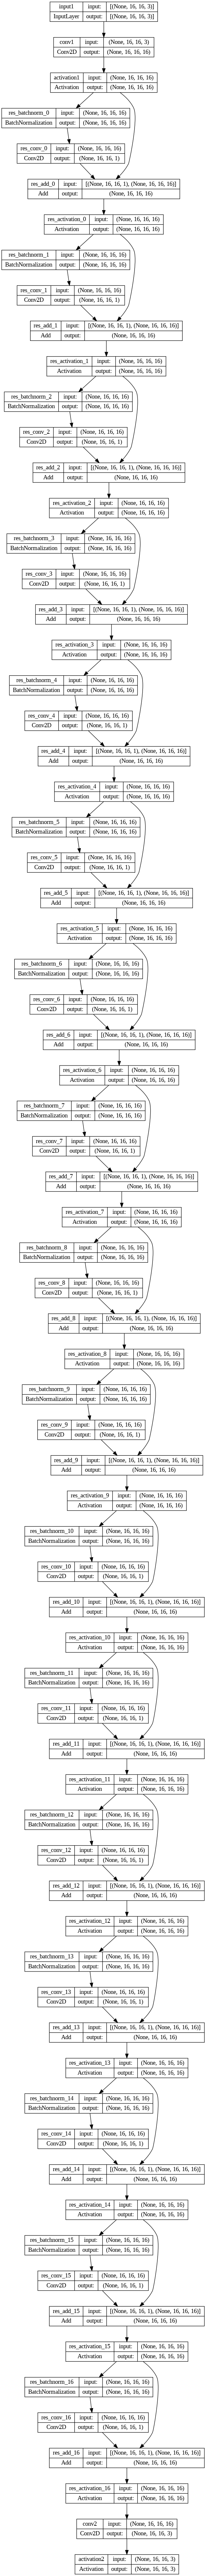

In [ ]:

plot_model(model2, 'res_model.png')
plot_model(model2, 'res_model_shape.png', True)

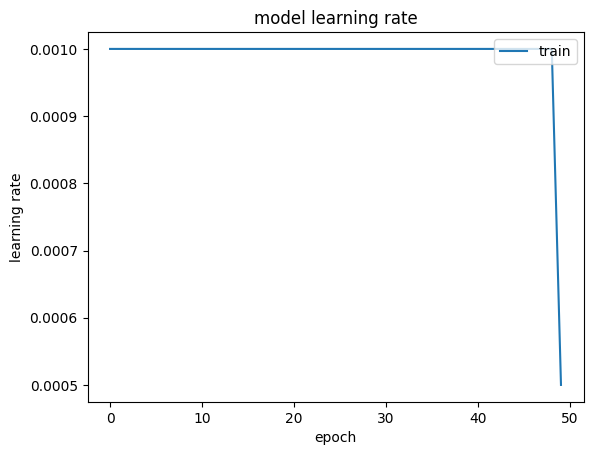

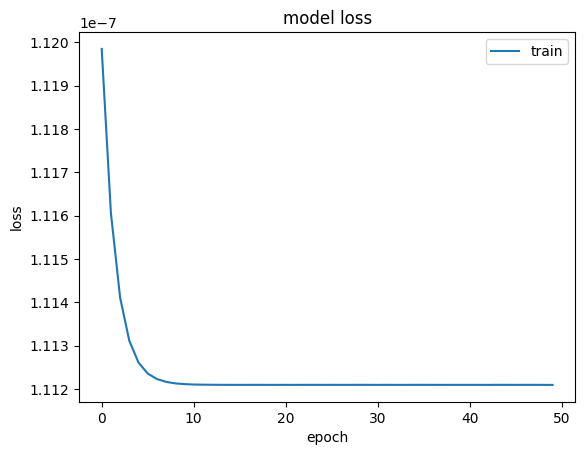

In [ ]:
plt.plot(history2.history['lr'])
plt.title('model learning rate')
plt.ylabel('learning rate')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.savefig('res150-30-lr.png')
plt.show()
plt.plot(history2.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.savefig('res150-30-loss.png')
plt.show()

In [ ]:
import shutil

# Save the model and weights
model2.save('resmodel_150_30.h5')
model2.save_weights('resmodel_150_30_weights.h5')

# Define the source and destination paths
source_model_path = 'resmodel_150_30.h5'
destination_model_path = '/content/drive/MyDrive/resmodel_150_30.h5'

source_weights_path = 'resmodel_150_30_weights.h5'
destination_weights_path = '/content/drive/MyDrive/resmodel_150_30_weights.h5'

# Copy the files to Google Drive
shutil.copyfile(source_model_path, destination_model_path)
shutil.copyfile(source_weights_path, destination_weights_path)


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


'/content/drive/MyDrive/resmodel_150_30_weights.h5'

1/1 [==============================] - 1s 539ms/step


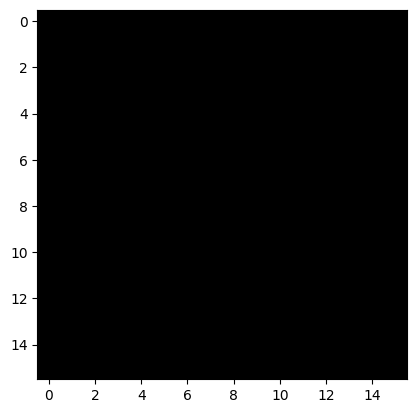

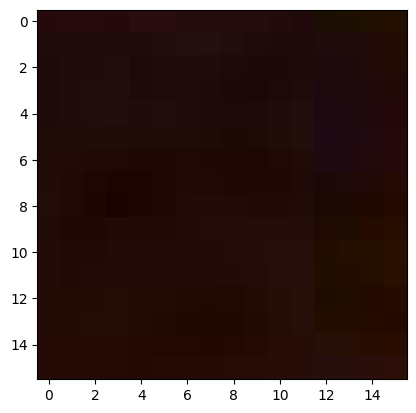

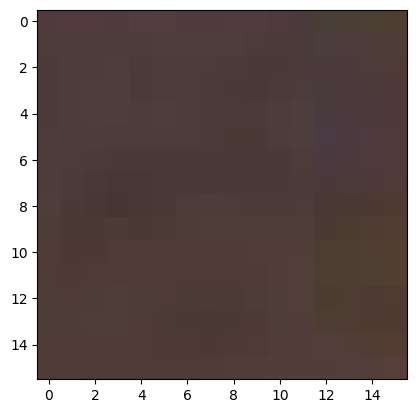

In [ ]:
t = np.expand_dims(residual_input[7], axis=0)
T = model2.predict(t)
plt.imshow(residual_input[7]-T[0])
plt.show()
plt.imshow(clean_image[7])
plt.show()
plt.imshow(haze_image[7])
plt.show()
